In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("./modules/") # for d3plus2

sys.path.append("./../Hidalgo_Haussmann") # for HH tools
from HH_tools import *

import d3plus2 as d3plus

import numpy as np

In [2]:
path = './../growth-lab-diversity/data/sources/'
agglevel_titles = pd.read_csv(path+'agglevel_titles.csv')
area_titles = pd.read_csv(path+'area_titles.csv')
industry_titles = pd.read_csv(path+'industry_titles.csv')
industry_titles =  pd.DataFrame([['POPESTIMATE2010','Population']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)
industry_titles =  pd.DataFrame([['Cropland','Cropland'],
                                ['Desert','Desert'],
                                ['Grassland','Grassland'],
                                ['Other','Other'],
                                ['Woodland','Woodland'],
                                ['Urban','Urban'],
                                ['Water','Water']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)

In [3]:
path = './../growth-lab-diversity/data/sources/BLS/'

uc = ['area_fips', 'industry_code', 'agglvl_code', 'year', 'annual_avg_estabs', 'annual_avg_emplvl', 'total_annual_wages']

df_list = []
for y in np.arange(2006, 2016):
    df_y = pd.read_csv(path+str(y)+'_annual_singlefile.zip', usecols = uc, low_memory=False)
    df_list += [df_y]
    
df = pd.concat(df_list)

In [4]:
# Get robustness from using 10 years

variable = 'annual_avg_estabs'
#correct possible mistakes, index should be like c-p-y
cpy_ix = df.loc[df.agglvl_code == 76].groupby(['year', 'area_fips', 'industry_code'])[[variable]].sum()
year_avg = cpy_ix.reset_index().drop('year', axis = 1).groupby(['area_fips', 'industry_code'])[[variable]].mean()
# summary_var = df_2015.drop('year', axis = 1).loc[df_2015.agglvl_code == 76].groupby(['area_fips', 'industry_code'])[[variable]].sum()
X = year_avg.unstack()[variable]


In [5]:
X.shape

(3279, 319)

In [6]:
# Add population

county_LU = pd.read_csv('./data/US_land_use/land_use_frac.csv', index_col=0)
county_LU.index = county_LU.index.astype(str).str.zfill(5)

In [7]:
# plt.hist(log10(county_LU['Woodland']).dropna(), 50)
# plt.show()

In [8]:
# Add population

county_pop = pd.read_csv('./data/co-est2017-alldata.csv')
county_pop['area_fips'] = county_pop.STATE.astype(str).str.zfill(2) + county_pop.COUNTY.astype(str).str.zfill(3)

county_pop = county_pop[['area_fips', 'POPESTIMATE2010']].set_index('area_fips')

In [9]:
X = pd.concat([county_pop.loc[X.index], county_LU.loc[X.index], X], axis = 1, sort = True)#.dropna()

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [10]:
# # Check sparsity / small areas
# # df_ = summary_var.groupby('area_fips').count().sort_values(by = variable)
# # pd.concat([df_, industry_titles.set_index('industry_code')], axis = 1, sort = False)
# # pd.concat([df_, area_titles.set_index('area_fips')], axis = 1, sort = False).dropna()

# # # Check what different choices do. 
# # # Final recommendation, take logs, don't fill gaps and use min periods >~ 20. (meth_3)

# # meth_1 = log10(summary_var.unstack()[variable]).fillna(-2).cov()
# # meth_2 = log10(summary_var.unstack()[variable]).fillna(-1).cov()
# # meth_3 = log10(summary_var.unstack()[variable]).cov(min_periods = 20).fillna(0)

# # plt.hist(meth_1.values.flatten().clip(-100, 1000), 100, linewidth = 0, alpha = .4)
# # plt.hist(meth_2.values.flatten().clip(-100, 1000), 100, linewidth = 0, alpha = .4)
# # plt.hist(meth_3.values.flatten().clip(-100, 1000), 100, linewidth = 0, alpha = .4)
# # plt.show()

# # x = meth_2.iloc[40] # meth_2.stack()
# # y = meth_3.iloc[40] # meth_3.stack()
# # plt.plot(x.values, y.values, marker = '.', alpha = .2, linewidth = 0)

# # M = log10(X)
# # M = (M.T - M.T.mean()).T

# cor_mat = log10(X).corr(min_periods = 20) # M -->log10(X)
# cov_mat = log10(X).cov(min_periods = 20)

# # We should be able to compare this to pearson correlation. 
# # However, removing area mean is necesary for this but note that row/col means are ill defined cause of logs of missing data... 
# # Here covariance can be compared to Pearson and plotted directly. It seems cov ~ pears^2

# # XTX = log10(X).T.fillna(0).dot(log10(X).fillna(0))
# # norm = np.sqrt(np.square(XTX).sum())
# # XTX = XTX.div(norm, axis = 0).div(norm) # this would convert it to Pearson if it was centered

# x = cor_mat.stack()
# y = cov_mat.stack()
# fig, ax = plt.subplots(1, figsize = (10, 10))
# ax.plot(x.values, y.values, marker = '.', alpha = .002, linewidth = 0)
# # ax.plot(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)**2)
# ax.set_xlim(-.2, 1.1); ax.set_ylim(-.2, 1.1); #ax.set_ylim(0, 0.00001)
# ax.set_xlabel('Correlation'); ax.set_ylabel('Covariance')

In [11]:
cor_mat = log10(X).corr(min_periods = 20)
cov_mat = log10(X).cov(min_periods = 20)

./../Hidalgo_Haussmann/HH_tools.py:58: RuntimeWarning: divide by zero encountered in log10
  return np.log10(df).replace(-np.inf, np.nan)


In [12]:
def demean(Z):
    Z = Z.fillna(0)
    means = Z.mean()
    return (Z.T - means).T - means + means.mean()

def stand(Z):
    Z = Z.fillna(0)
    std = Z.std()
    return Z.T.div(std).T.div(std)

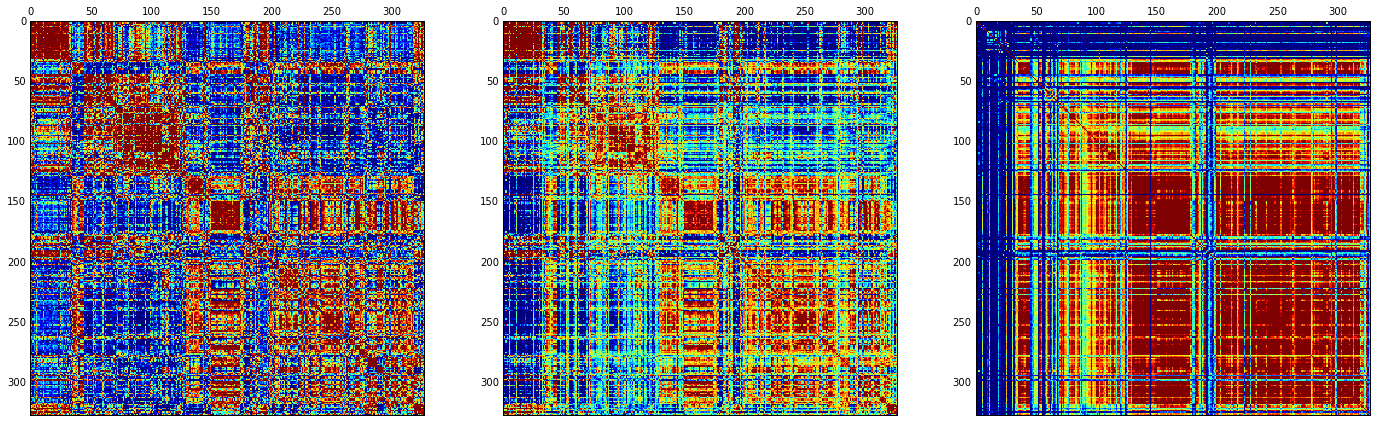

In [13]:
# mat = demean(cor_mat.fillna(0))
# mat = cor_mat
fig, axs = plt.subplots(1, 3, figsize = (24, 8))

axs[0].matshow(demean(stand(demean(cor_mat))), vmin = -10, vmax = 10)
axs[1].matshow(demean(cor_mat), vmin = -.1, vmax = .1)
axs[2].matshow(cor_mat.fillna(0), vmin = .2, vmax = .7)

# plt.hist(stand(demean(cor_mat)).std(), 30)
# plt.show()

In [14]:
# Try spectral clustering. Works when matrix is demeaned
from sklearn.cluster import SpectralClustering
X_ = demean(cor_mat).values
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0).fit(X_)

pd.options.display.max_rows = 500
clust_result = pd.DataFrame(clustering.labels_, index = X.columns, columns = ['cluster'])
clust_result = pd.concat([clust_result, industry_titles.set_index('industry_code')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'industry_title'])

/home/miglesia/anaconda2/lib/python2.7/site-packages/sklearn/cluster/spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


In [15]:
edges = pd.DataFrame(demean(cor_mat).stack(), columns = ['dem_corr'])
# > demean(cor_mat).values, 90
# edges.loc[]
edges_s = edges.loc[edges.dem_corr > edges.dem_corr.quantile(.9)]
edges_s.index.names = ['industry_code_x', 'industry_code_y']
edges_s = edges_s.reset_index().merge(
    industry_titles, left_on = 'industry_code_x', right_on = 'industry_code').merge(
    industry_titles, left_on = 'industry_code_y', right_on = 'industry_code').T.drop_duplicates().T
edges_s['dem_corr'] = edges_s['dem_corr'].astype(float)

In [16]:
# #Load modules
# from numpy.random import choice 
# from numpy import where, power

In [17]:
import matplotlib.colors as mcolors

# nodes = industry_titles

nodes_size = pd.DataFrame(np.sqrt(X.sum()), columns=['sqrt_size'])
nodes = pd.concat([nodes_size, clust_result], axis = 1, sort = False)

norm = mcolors.Normalize(vmin=0, vmax=10, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet)

nodes['color'] = nodes['cluster'].apply(lambda x: mcolors.rgb2hex(mapper.to_rgba(x)))

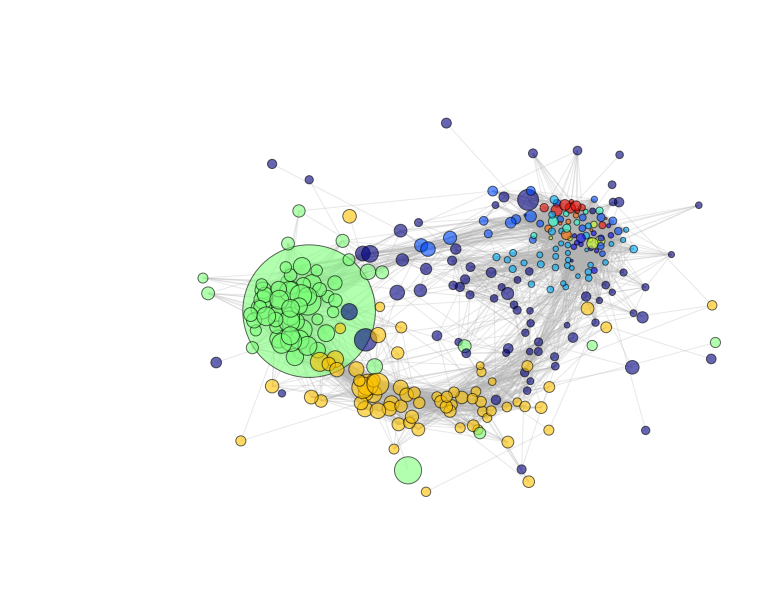

In [18]:
max_d = 200
weight_column = 'dem_corr' #'weight_'+geo

        ### Max degree = max_d. Parameter used to trim the network.
df1 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
df2 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
edges_max_d = df1.merge(df2, on = ['industry_code_x', 'industry_title_x', 'industry_code_y', 'industry_title_x', weight_column]).reset_index(drop = True)

###

# Hard threshold and max degree backboning

G = nx.from_pandas_edgelist(edges_max_d, 'industry_code_x', 'industry_code_y', weight_column)


plt.figure(figsize = (10, 8))

G = max(nx.connected_component_subgraphs(G), key=len)
nodes_s = nodes.loc[G.nodes.keys()]
pos = nx.spring_layout(G, k=.4)

nx.draw(G, pos, node_size = nodes_s.sqrt_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
# plt.title('max_d = '+str(max_d))
#     plt.savefig('./Figures/5_max_deg/'+col_name+'_plot1.png')
#             plt.show()

plt.show()

### Draw in d3plus

In [19]:
# nodes
pos_df = pd.DataFrame(pos, index = ['x', 'y']).T
nodes_wpos = pd.concat([nodes_s, pos_df], axis = 1, sort = False)

In [36]:
nodes_ = nodes_wpos.reset_index()[['index','x', 'y', 'industry_title', 'color']].dropna(subset = ['x']).rename({'index': 'id'}, axis = 1)
nodes_['id'] = nodes_['id'].astype(str).str.zfill(4)
nodes_[['x', 'y']] = 500 * nodes_[['x', 'y']]


In [37]:
nodes_.head()

id           x           y  \
0  1142  219.031733  173.327239   
1  5173   24.030574 -188.176262   
2  1141  126.045804  198.411937   
3  3335   40.957087   70.918413   
4  5175  250.904213  299.597448   

                                      industry_title    color  
0                    NAICS 1142 Hunting and trapping  #0000f1  
1  NAICS 5173 Wired and wireless telecommunicatio...  #ffc400  
2                                 NAICS 1141 Fishing  #004cff  
3    NAICS 3335 Metalworking machinery manufacturing  #000080  
4  NAICS02 5175 Cable and other program distribution  #000080

In [264]:
# nodes_.sort_values(by = 'id')#.loc[nodes_.id == 'Desert']

id           x           y  \
183  1111             171.437771  169.647354   
261  1112             132.975764  239.865186   
260  1113             169.067437  247.041705   
263  1114             43.652845   283.063339   
264  1119             188.165841  244.280308   
92   1121             154.657474  233.014997   
93   1122             140.245095  185.541520   
199  1123             198.625008  240.310164   
95   1124             180.419917  255.325456   
96   1125             189.826634  201.591703   
87   1129             155.553686  251.199462   
133  1131             171.103811  224.092096   
132  1132             190.491656  230.894940   
131  1133             148.873900  204.174140   
2    1141             126.045804  198.411937   
0    1142             219.031733  173.327239   
45   1151             178.361839  238.884303   
48   1152             190.839961  388.620156   
47   1153             229.127038  232.063039   
195  2111             229.970934  153.656810   
285  2121             115.045078  167.329907   
287  2122             174.938890  203.538448   
286  2123             109.760975  283.660357   
251  2131             216.821429  146.913813   
210  2211            -36.794809   460.137354   
209  2212             288.438294  132.014042   
208  2213             74.836356   200.772458   
197  2361            -309.731780 -56.331248    
220  2362            -193.084892 -180.987159   
163  2371            -254.443037 -263.530011   
164  2372            -393.627727 -367.410361   
159  2379             183.014993 -98.363691    
262  2381            -307.604739 -93.656761    
125  2382            -306.362375 -106.821775   
124  2383            -278.066476 -120.046747   
128  2389            -245.460154 -86.885334    
297  3111             233.940804  194.161489   
206  3112             209.725043  192.486758   
295  3113             48.476847   246.671285   
294  3114             146.885735  221.603884   
227  3115             205.855732  167.209966   
292  3116             150.385696  260.764337   
291  3117             184.602902  138.106577   
290  3118            -436.437204 -163.378175   
289  3119            -85.154732   201.110971   
165  3121             113.494552  381.430846   
24   3122             244.878213  192.870727   
52   3131             189.775796  148.753263   
293  3132             231.745445  160.723427   
54   3133             210.434607  56.619886    
213  3141             308.761079  32.803139    
138  3151             214.351753  134.071271   
152  3152             205.755021  8.572453     
178  3159             213.535097  90.627035    
180  3161             197.029727  144.337556   
177  3162             224.063756  127.657477   
173  3169             239.454405  97.278797    
205  3211             172.186410  186.507325   
185  3212             199.957275  214.265933   
190  3219             63.211076   267.765894   
266  3221             174.097013  142.496255   
298  3222            -25.049945   37.580714    
249  3231            -229.561071 -1.919449     
71   3241             270.799230  70.913110    
25   3251             239.873348  38.141361    
26   3252             152.597134  84.034290    
27   3253             220.147189  261.781722   
167  3254             103.533499 -236.683657   
29   3255             86.661019   51.749098    
30   3256             109.507682 -61.223442    
130  3259             80.683160  -13.019700    
136  3261            -20.496204   132.316617   
139  3262             78.314551   80.238604    
103  3271             143.739276  26.739290    
101  3272             288.079839 -34.915145    
228  3273            -459.445072  56.582639    
100  3274             249.666861  145.406094   
143  3311             153.015864  112.981262   
145  3312             125.408798  117.010646   
144  3313             153.147144  132.847489   
204  3314             173.325869  89.263658    
146  3315             79.037080   121.962414   
12   3321             50.151715   

In [39]:
import sys
sys.path.append("./../Hidalgo_Haussmann") # for HH tools
import pandas as pd
from HH_tools import robust_proximity, year_to_tp, RCA

In [40]:
nodes_['presence'] = True

edges_max_d['edge_tuple'] = list(zip(edges_max_d.industry_code_x, edges_max_d.industry_code_y))
edges_max_d['edge_tuple_rev'] = list(zip(edges_max_d.industry_code_y, edges_max_d.industry_code_x))
edges_max_d_triangles = edges_max_d.loc[edges_max_d.edge_tuple.isin(G.edges()) | edges_max_d.edge_tuple_rev.isin(G.edges())]

links = edges_max_d_triangles.reset_index().rename({weight_column: 'strength'},axis = 1)
links['target'] = links['industry_code_y'].astype(str).str.zfill(4)
links['source'] = links['industry_code_x'].astype(str).str.zfill(4)

# links = nc_backbone.reset_index().rename({'score': 'strength'},axis = 1)
# links['target'] = links['trg'].astype(str).str.zfill(4)
# links['source'] = links['src'].astype(str).str.zfill(4)

network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'
# network

In [101]:
(-nodes_['industry_title'].str.lower().str.contains('naics'))

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      True 
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     True 
22     True 
23     False
24     False
25     False
26     False
27     False
28     False
29     False
30     False
31     False
32     False
33     False
34     False
35     False
36     False
37     False
38     False
39     False
40     False
41     False
42     False
43     False
44     False
45     False
46     False
47     False
48     False
49     False
50     False
51     False
52     False
53     False
54     False
55     False
56     False
57     False
58     False
59     False
60     False
61     False
62     False
63     False
64     False
65     False
66     False
67     False
68     False
69     False
70     False
71     False
72     False
73     False
74     False
75     False
76     False

In [104]:
## Conditional coloring

# Manufacturing (light_blue) and services (yellow)
nodes_['color_mfg_srv'] = 'D3D3D3' #Gray bckg

conditions = [
    (nodes_['industry_title'].str.lower().str.contains('manufacturing')) + (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('service')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('wholesale')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (-nodes_['industry_title'].str.lower().str.contains('naics'))]

choices = ['#000080', '#ffc400', '#00b0ff', '#000000']

nodes_['color_mfg_srv'] = np.select(conditions, choices, default='#D3D3D3')


In [41]:
edges_max_d_triangles.to_csv('edges_max_d_triangles.csv', index = False)

In [105]:
ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color="color_mfg_srv",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Activities by cluster

In [88]:
pd.set_option('display.max_colwidth', -1)
summary = nodes.loc[nodes.industry_title.str.contains('NAICS')].groupby('cluster').agg({'industry_title': 'first', 'color':[ 'first', 'count']})
summary.columns = ['color', 'node_count','example']
summary.sort_index()#.sort_values(by = 'node_count')

color  node_count  \
cluster                        
0.0      #000080  80           
1.0      #0000f1  12           
2.0      #004cff  22           
3.0      #00b0ff  36           
4.0      #29ffce  6            
5.0      #7dff7a  69           
6.0      #ceff29  6            
7.0      #ffc400  76           
8.0      #ff6800  3            
9.0      #f10800  9            

                                                     example  
cluster                                                       
0.0      NAICS 1152 Support activities for animal production  
1.0      NAICS 1142 Hunting and trapping                      
2.0      NAICS 1114 Greenhouse and nursery production         
3.0      NAICS 2212 Natural gas distribution                  
4.0      NAICS 1125 Aquaculture                               
5.0      NAICS 2361 Residential building construction         
6.0      NAICS 2111 Oil and gas extraction                    
7.0      NAICS 2362 Nonresidential building construction      
8.0      NAICS 1111 Oilseed and grain farming                 
9.0      NAICS 1112 Vegetable and melon farming

### Keywords by cluster

In [91]:
# Cluster 7, #ffc400 are 76 nodes that follow neither population nor land resources. Then what is it all about?
from collections import Counter
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

    
for cl in range(10):
    text = nodes.loc[nodes.cluster == cl]['industry_title']

    r1 = text.str.lower().str.split().values
    r1 = [item for sublist in r1 for item in sublist]

    r1_f = [w.replace(',', '').replace('mfg.', 'manufacturing') for w in r1 if not w in stop_words] 

    print(summary.loc[cl])
    print(Counter(r1_f).most_common()[:10])
    print('\n')


color         #000080                                            
node_count    80                                                 
example       NAICS 1152 Support activities for animal production
Name: 0.0, dtype: object
[('naics', 79), ('manufacturing', 33), ('product', 11), ('equipment', 6), ('transportation', 4), ('general', 4), ('machinery', 4), ('facilities', 3), ('merchant', 3), ('furniture', 3)]


color         #0000f1                        
node_count    12                             
example       NAICS 1142 Hunting and trapping
Name: 1.0, dtype: object
[('naics', 12), ('transportation', 3), ('mills', 3), ('product', 2), ('manufacturing', 2), ('1142', 1), ('coastal', 1), ('4245', 1), ('packaging', 1), ('raw', 1)]


color         #004cff                                     
node_count    22                                          
example       NAICS 1114 Greenhouse and nursery production
Name: 2.0, dtype: object
[('naics', 22), ('transportation', 4), ('water', 3), ('manuf

In [260]:
edges_max_d_triangles.head()

industry_code_x industry_code_y  dem_corr  \
0  1111            1111            1.553765   
1  1111            4245            0.803855   
2  1111            1122            0.800740   
3  1111            Cropland        0.735355   
4  1111            1151            0.716539   

                       industry_title_x  \
0  NAICS 1111 Oilseed and grain farming   
1  NAICS 1111 Oilseed and grain farming   
2  NAICS 1111 Oilseed and grain farming   
3  NAICS 1111 Oilseed and grain farming   
4  NAICS 1111 Oilseed and grain farming   

                                  industry_title_y_x  \
0  NAICS 1111 Oilseed and grain farming                
1  NAICS 4245 Farm product raw material merch. whls.   
2  NAICS 1122 Hog and pig farming                      
3  Cropland                                            
4  NAICS 1151 Support activities for crop production   

                                  industry_title_y_y        edge_tuple  \
0  NAICS 1111 Oilseed and grain farming               (1111, 1111)       
1  NAICS 4245 Farm product raw material merch. whls.  (1111, 4245)       
2  NAICS 1122 Hog and pig farming                     (1111, 1122)       
3  Cropland                                           (1111, Cropland)   
4  NAICS 1151 Support activities for crop production  (1111, 1151)       

     edge_tuple_rev  
0  (1111, 1111)      
1  (4245, 1111)      
2  (1122, 1111)      
3  (Cropland, 1111)  
4  (1151, 1111)

In [273]:
### A little trick. Distribution of neigbors of node 'Naics 5417 Scientific Research and Development Services'
# nodes_.loc[nodes_.id == '5417']
ego_node = 'Desert' #'Cropland' #'POPESTIMATE2010'# '5417'

neigh = edges_max_d_triangles.loc[(edges_max_d_triangles.industry_code_x == ego_node) |
                                  (edges_max_d_triangles.industry_code_y == ego_node)]
neigh_ids = list(set(neigh['industry_code_x'].unique()).union(set(neigh['industry_code_y'].unique())))
nodes_.loc[nodes_.id.isin(neigh_ids)]['id'].values

array(['1142', '1141', '3335', '5174', 'Woodland', '3321', '3322', '3325',
       '7114', '3122', '3252', '9281', '4869', '3361', '4862', '9271',
       '4882', '1151', '1153', '3131', '3336', '3133', '4871', '3379',
       '4872', '4879', '1121', '1122', '1124', '1125', 'Cropland', '3274',
       '3272', '3271', '7132', 'Water', '1133', '1131', '3151', '3262',
       '3311', '3313', '3312', '3315', '3369', '4811', '3365', '9241',
       '3362', '3169', '3159', '3161', '1111', '3212', '3364', '3366',
       '5122', '2111', 'Desert', '1123', '3314', '3211', '3112', '4245',
       'Other', '7213', '2131', '3342', '3343', '3341', '6222', '1113',
       '1112', '1119', '3221', '5251', '3353', '3352', 'Grassland', '3359',
       '2121', '2123', '2122', '3117', '3132', '4851', '4855', '4852'], dtype=object)

In [274]:
#Filter original data to have these neighboring industries
df_agglv = df.loc[df.agglvl_code == 76]

df_agglv_yravg = df_agglv.groupby(['area_fips', 'industry_code']).mean().drop(['agglvl_code','year'], axis = 1)
df_indu_prc_area = df_agglv_yravg.groupby(level=0).apply(lambda x: 100 * x / x.sum())

df_ = df_indu_prc_area.reset_index()

df_neigh = df_.loc[df_.industry_code.isin(nodes_.loc[nodes_.id.isin(neigh_ids)]['id'].values)]
df_neigh = df_neigh.set_index('area_fips')

In [275]:
# nodes
import geopandas as gpd

counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP
counties = counties.set_index('area_fips').reindex(df_neigh.index)[['geometry']]

gdf = gpd.GeoDataFrame(pd.concat([df_neigh, counties], axis = 1, sort = True).dropna())

In [245]:
from IPython.display import display, HTML

industry_code  annual_avg_estabs  annual_avg_emplvl  \
area_fips                                                       
01001      4234          0.114890           0.000000            
01003      4234          0.099287           0.052085            
01009      4234          0.244305           0.000000            
01013      4234          0.187383           0.000000            
01015      4234          0.176574           0.129017            

           total_annual_wages  \
area_fips                       
01001      0.000000             
01003      0.104715             
01009      0.000000             
01013      0.000000             
01015      0.164528             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

id           x           y                        industry_title  \
183  1111  171.437771  169.647354  NAICS 1111 Oilseed and grain farming   

       color  presence color_mfg_srv  
183  #ff6800  True      #D3D3D3

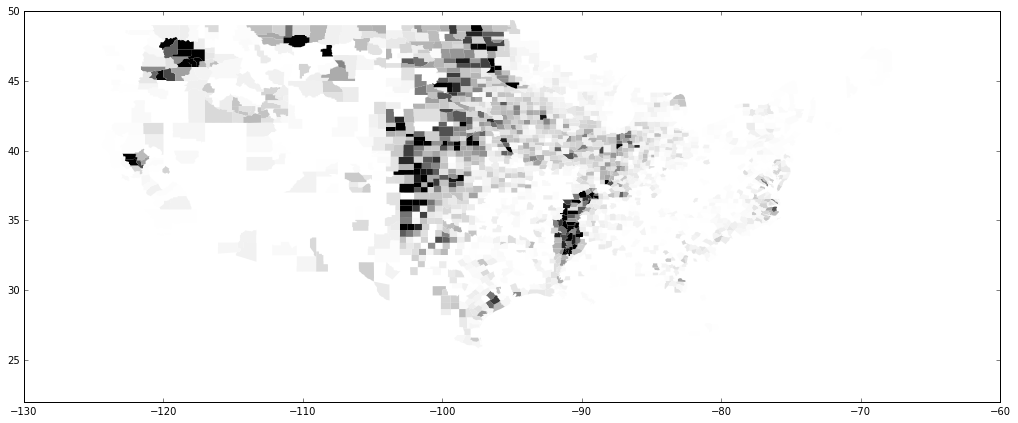

id           x           y                 industry_title    color  \
264  1119  188.165841  244.280308  NAICS 1119 Other crop farming  #f10800   

     presence color_mfg_srv  
264  True      #D3D3D3

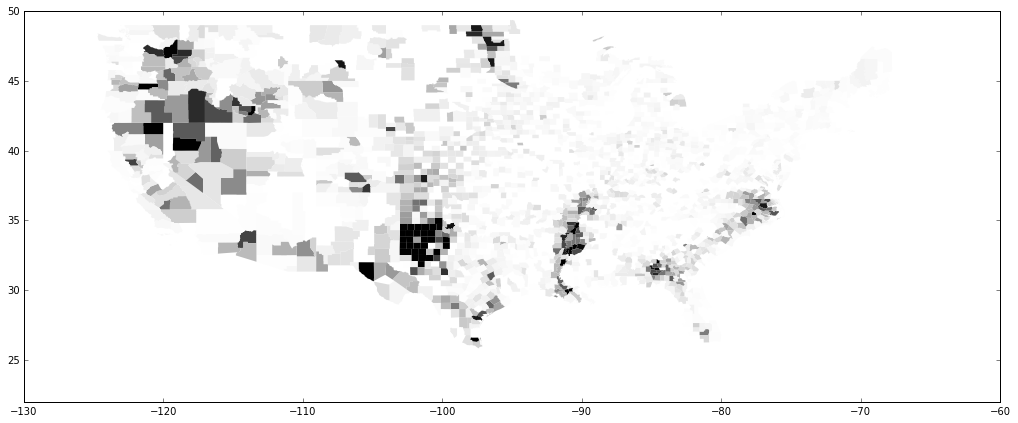

id           x           y                          industry_title  \
92  1121  154.657474  233.014997  NAICS 1121 Cattle ranching and farming   

      color  presence color_mfg_srv  
92  #f10800  True      #D3D3D3

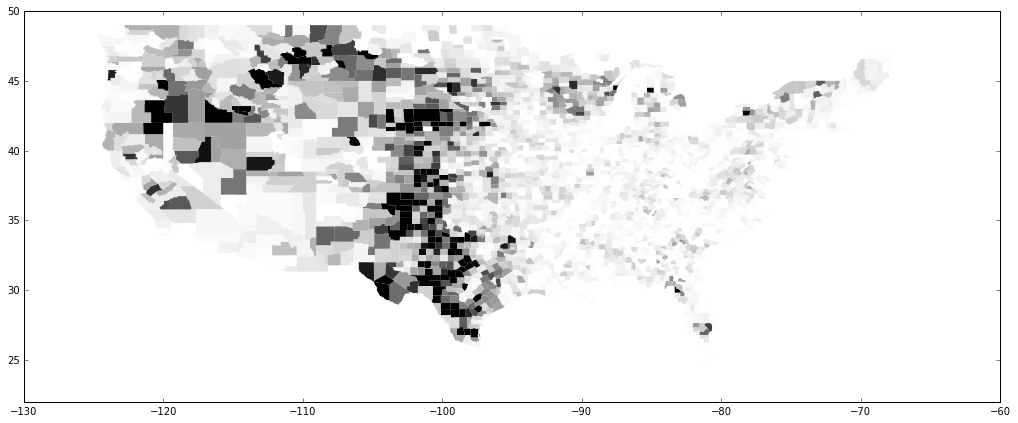

id         x          y      industry_title    color  presence  \
131  1133  148.8739  204.17414  NAICS 1133 Logging  #29ffce  True       

    color_mfg_srv  
131  #D3D3D3

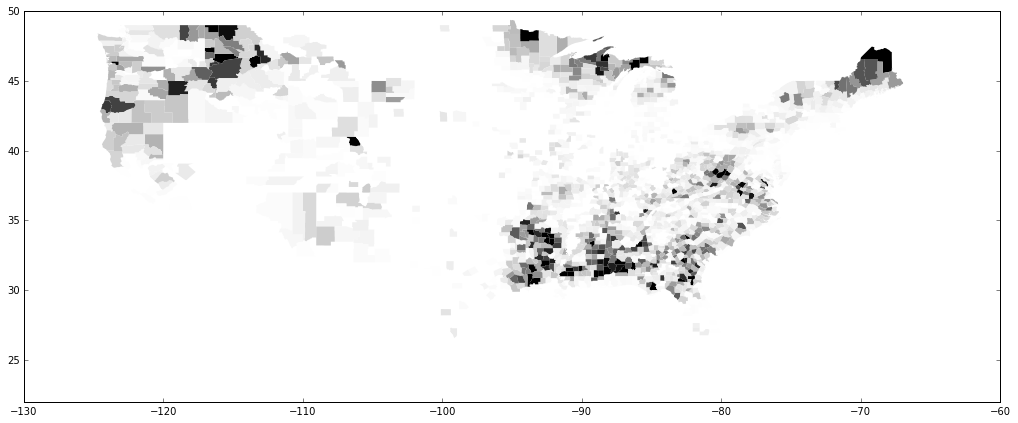

id           x           y  \
45  1151  178.361839  238.884303   

                                       industry_title    color  presence  \
45  NAICS 1151 Support activities for crop production  #f10800  True       

   color_mfg_srv  
45  #D3D3D3

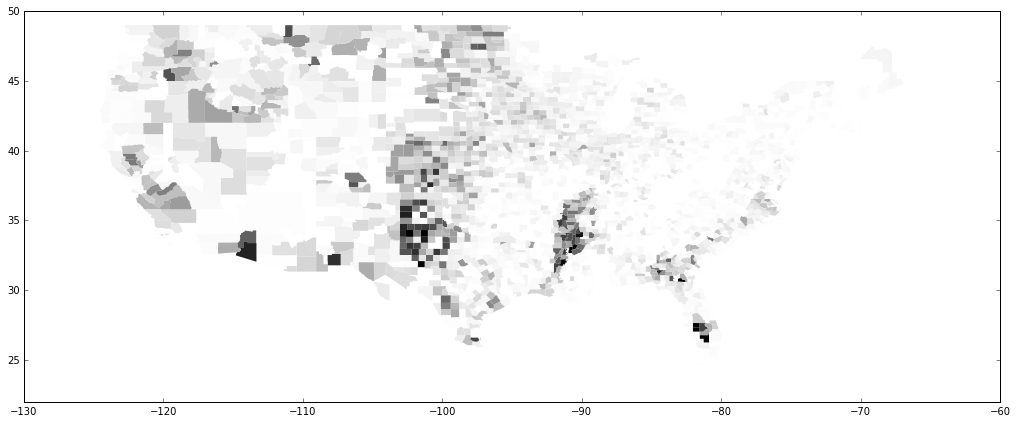

id           x           y                              industry_title  \
47  1153  229.127038  232.063039  NAICS 1153 Support activities for forestry   

      color  presence color_mfg_srv  
47  #29ffce  True      #D3D3D3

id           x           y  \
286  2123  109.760975  283.660357   

                                          industry_title    color  presence  \
286  NAICS 2123 Nonmetallic mineral mining and quarrying  #004cff  True       

    color_mfg_srv  
286  #D3D3D3

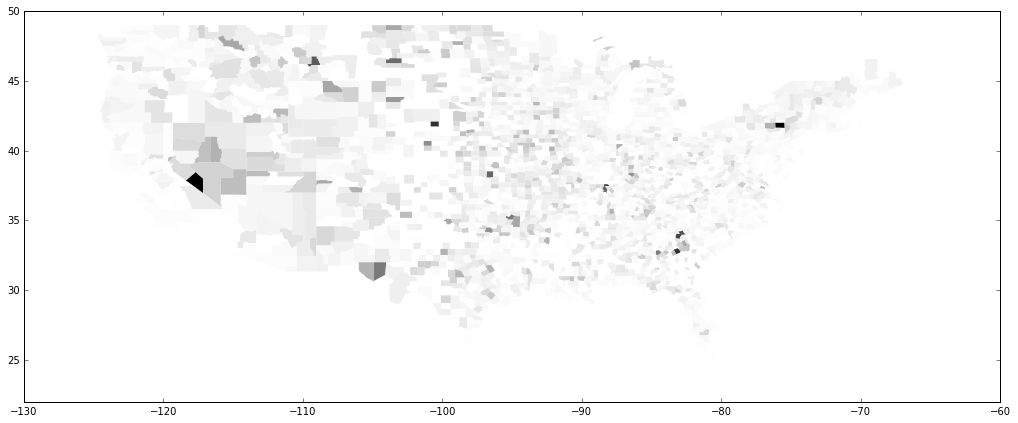

id           x          y  \
173  3169  239.454405  97.278797   

                                     industry_title    color  presence  \
173  NAICS 3169 Other leather product manufacturing  #00b0ff  True       

    color_mfg_srv  
173  #000080

id           x           y  \
266  3221  174.097013  142.496255   

                                   industry_title    color  presence  \
266  NAICS 3221 Pulp, paper, and paperboard mills  #00b0ff  True       

    color_mfg_srv  
266  #D3D3D3

id         x         y                                 industry_title  \
279  3353  46.10505  3.581681  NAICS 3353 Electrical equipment manufacturing   

       color  presence color_mfg_srv  
279  #000080  True      #000080

id           x           y  \
186  3364  252.526893  254.734056   

                                           industry_title    color  presence  \
186  NAICS 3364 Aerospace product and parts manufacturing  #000080  True       

    color_mfg_srv  
186  #000080

id           x           y  \
234  4245  196.873522  160.519573   

                                        industry_title    color  presence  \
234  NAICS 4245 Farm product raw material merch. whls.  #0000f1  True       

    color_mfg_srv  
234  #D3D3D3

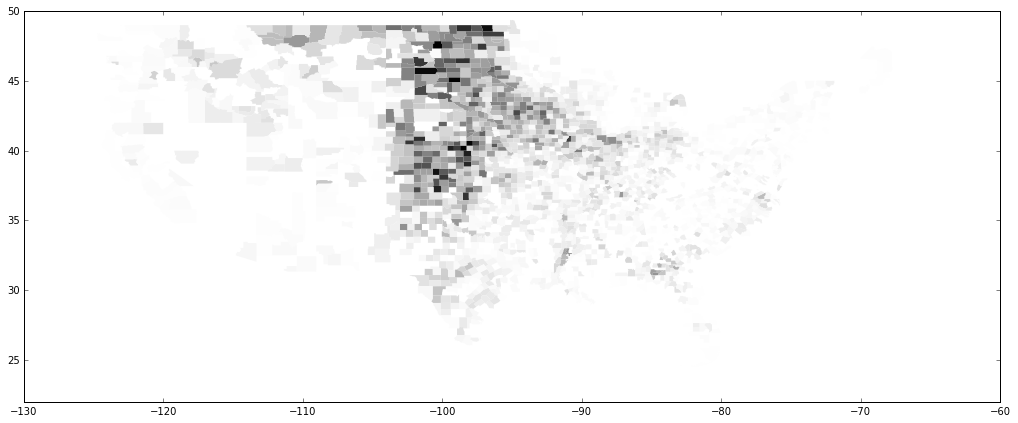

id           x          y  \
43  4882  209.595351  72.561924   

                                           industry_title    color  presence  \
43  NAICS 4882 Support activities for rail transportation  #00b0ff  True       

   color_mfg_srv  
43  #D3D3D3

id           x           y                          industry_title  \
244  7213  231.121822  140.091779  NAICS 7213 Rooming and boarding houses   

       color  presence color_mfg_srv  
244  #004cff  True      #D3D3D3

id           x           y  \
166  9241  109.586116  217.413515   

                                          industry_title    color  presence  \
166  NAICS 9241 Administration of environmental programs  #004cff  True       

    color_mfg_srv  
166  #D3D3D3

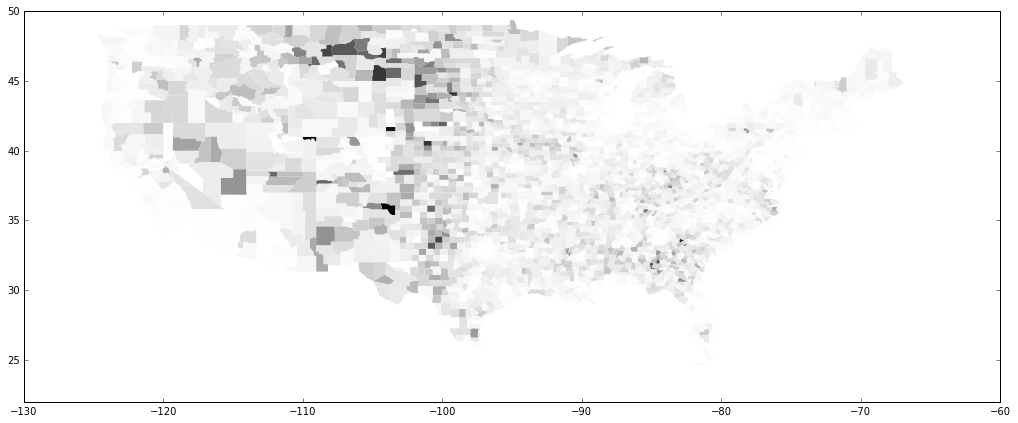

id          x           y                            industry_title  \
39  9271  144.50316  161.379827  NAICS 9271 Space research and technology   

      color  presence color_mfg_srv  
39  #ceff29  True      #D3D3D3

id           x           y                          industry_title  \
261  1112  132.975764  239.865186  NAICS 1112 Vegetable and melon farming   

       color  presence color_mfg_srv  
261  #f10800  True      #D3D3D3

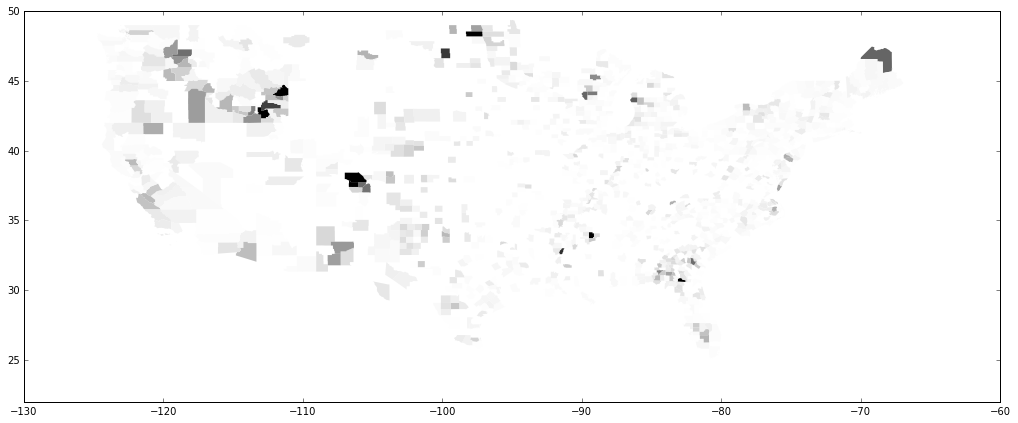

id           x           y                         industry_title  \
260  1113  169.067437  247.041705  NAICS 1113 Fruit and tree nut farming   

       color  presence color_mfg_srv  
260  #f10800  True      #D3D3D3

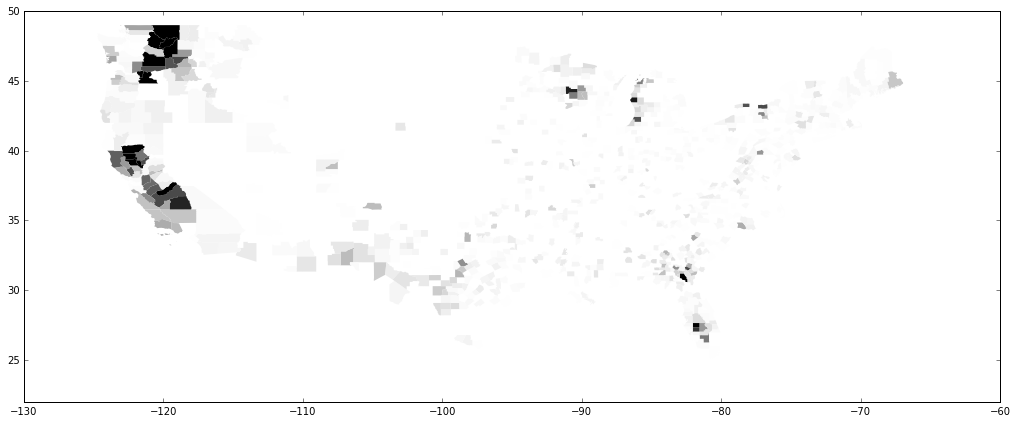

id           x           y                         industry_title  \
199  1123  198.625008  240.310164  NAICS 1123 Poultry and egg production   

       color  presence color_mfg_srv  
199  #f10800  True      #D3D3D3

id           x           y          industry_title    color  presence  \
96  1125  189.826634  201.591703  NAICS 1125 Aquaculture  #29ffce  True       

   color_mfg_srv  
96  #D3D3D3

id           x           y                      industry_title  \
133  1131  171.103811  224.092096  NAICS 1131 Timber tract operations   

       color  presence color_mfg_srv  
133  #29ffce  True      #D3D3D3

id           x           y      industry_title    color  presence  \
2  1141  126.045804  198.411937  NAICS 1141 Fishing  #004cff  True       

  color_mfg_srv  
2  #D3D3D3

id           x          y                     industry_title    color  \
195  2111  229.970934  153.65681  NAICS 2111 Oil and gas extraction  #ceff29   

     presence color_mfg_srv  
195  True      #D3D3D3

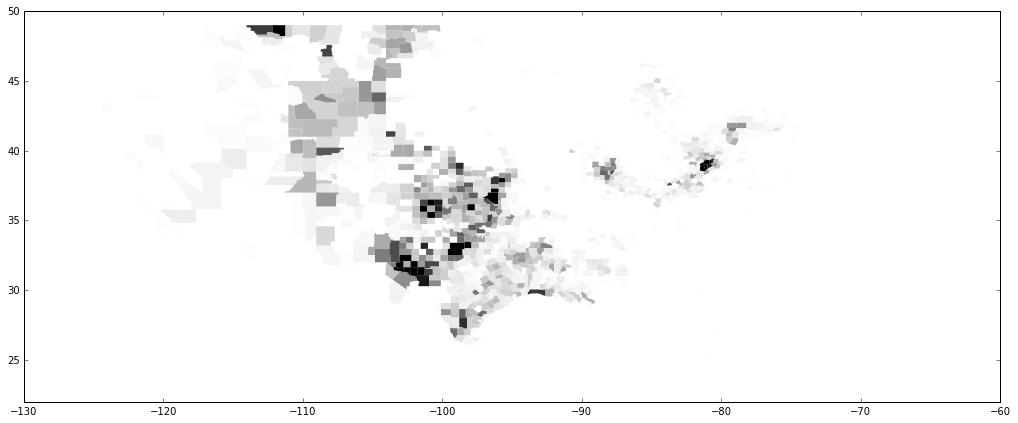

id           x           y                            industry_title  \
251  2131  216.821429  146.913813  NAICS 2131 Support activities for mining   

       color  presence color_mfg_srv  
251  #ceff29  True      #D3D3D3

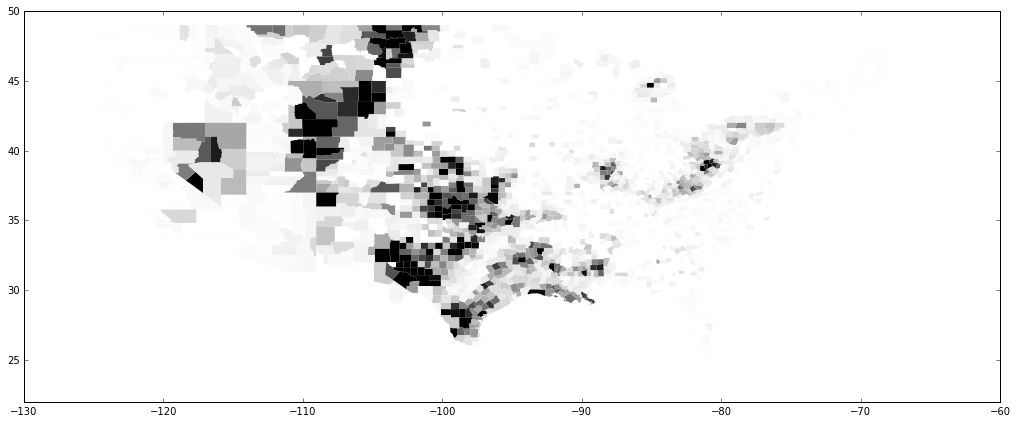

id           x           y  \
291  3117  184.602902  138.106577   

                                           industry_title    color  presence  \
291  NAICS 3117 Seafood product preparation and packaging  #0000f1  True       

    color_mfg_srv  
291  #D3D3D3

id           x           y                    industry_title    color  \
24  3122  244.878213  192.870727  NAICS 3122 Tobacco manufacturing  #0000f1   

    presence color_mfg_srv  
24  True      #000080

id           x           y           industry_title    color  presence  \
293  3132  231.745445  160.723427  NAICS 3132 Fabric mills  #0000f1  True       

    color_mfg_srv  
293  #D3D3D3

id          x           y                             industry_title  \
205  3211  172.18641  186.507325  NAICS 3211 Sawmills and wood preservation   

       color  presence color_mfg_srv  
205  #29ffce  True      #D3D3D3

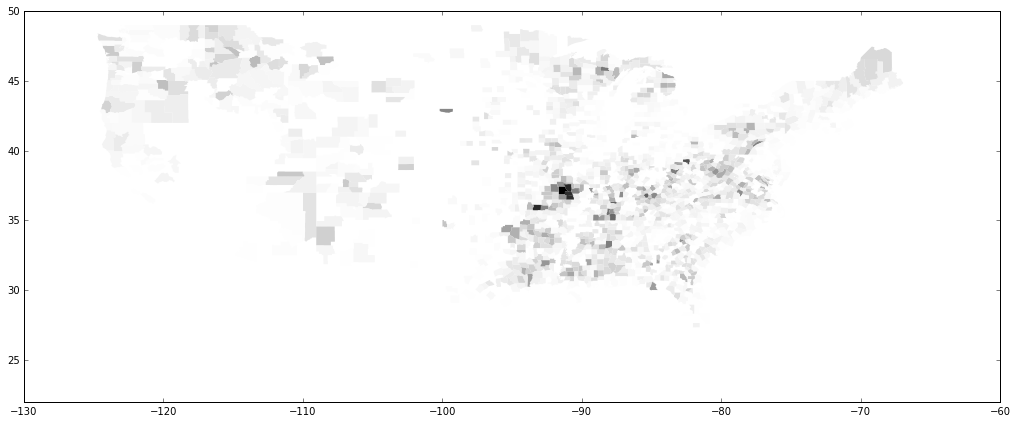

id           x           y  \
185  3212  199.957275  214.265933   

                                          industry_title    color  presence  \
185  NAICS 3212 Plywood and engineered wood product mfg.  #004cff  True       

    color_mfg_srv  
185  #000080

id           x         y  \
26  3252  152.597134  84.03429   

                                          industry_title    color  presence  \
26  NAICS 3252 Resin, rubber, and artificial fibers mfg.  #00b0ff  True       

   color_mfg_srv  
26  #000080

id          x          y                           industry_title  \
139  3262  78.314551  80.238604  NAICS 3262 Rubber product manufacturing   

       color  presence color_mfg_srv  
139  #00b0ff  True      #000080

id           x         y  \
103  3271  143.739276  26.73929   

                                           industry_title    color  presence  \
103  NAICS 3271 Clay product and refractory manufacturing  #00b0ff  True       

    color_mfg_srv  
103  #000080

id           x          y  \
204  3314  173.325869  89.263658   

                                   industry_title    color  presence  \
204  NAICS 3314 Other nonferrous metal production  #00b0ff  True       

    color_mfg_srv  
204  #D3D3D3

id         x           y        industry_title    color  presence  \
146  3315  79.03708  121.962414  NAICS 3315 Foundries  #00b0ff  True       

    color_mfg_srv  
146  #D3D3D3

id           x          y  \
13  3322  110.813077  40.658777   

                                   industry_title    color  presence  \
13  NAICS 3322 Cutlery and handtool manufacturing  #00b0ff  True       

   color_mfg_srv  
13  #000080

id          x          y  \
3  3335  40.957087  70.918413   

                                    industry_title    color  presence  \
3  NAICS 3335 Metalworking machinery manufacturing  #000080  True       

  color_mfg_srv  
3  #000080

id          x         y  \
53  3336  98.053385  96.06307   

                                              industry_title    color  \
53  NAICS 3336 Turbine and power transmission equipment mfg.  #00b0ff   

    presence color_mfg_srv  
53  True      #000080

id           x          y  \
283  3359  100.344848 -85.900724   

                                               industry_title    color  \
283  NAICS 3359 Other electrical equipment and component mfg.  #000080   

     presence color_mfg_srv  
283  True      #000080

id           x           y  \
172  3362  146.290346  177.987553   

                                              industry_title    color  \
172  NAICS 3362 Motor vehicle body and trailer manufacturing  #00b0ff   

     presence color_mfg_srv  
172  True      #000080

id           x           y                     industry_title    color  \
188  3366  199.261518  186.247352  NAICS 3366 Ship and boat building  #004cff   

     presence color_mfg_srv  
188  True      #D3D3D3

id          x           y  \
67  3379  217.08863  231.453931   

                                              industry_title    color  \
67  NAICS 3379 Other furniture related product manufacturing  #000080   

    presence color_mfg_srv  
67  True      #000080

id         x          y                   industry_title    color  \
305  4855  251.2098  19.513598  NAICS 4855 Charter bus industry  #000080   

     presence color_mfg_srv  
305  True      #D3D3D3

id          x           y  \
68  4872  160.66946  209.684085   

                                             industry_title    color  \
68  NAICS 4872 Scenic and sightseeing transportation, water  #004cff   

    presence color_mfg_srv  
68  True      #D3D3D3

id           x           y                         industry_title  \
194  5122  122.821198 -134.730318  NAICS 5122 Sound recording industries   

       color  presence color_mfg_srv  
194  #000080  True      #D3D3D3

id           x           y  \
18  7114  123.310543 -109.762337   

                                       industry_title    color  presence  \
18  NAICS 7114 Agents and managers for public figures  #000080  True       

   color_mfg_srv  
18  #D3D3D3

id           x          y  \
28  9281  107.171261  73.836925   

                                            industry_title    color  presence  \
28  NAICS 9281 National security and international affairs  #000080  True       

   color_mfg_srv  
28  #D3D3D3

id          x           y               industry_title    color  \
287  2122  174.93889  203.538448  NAICS 2122 Metal ore mining  #ff6800   

     presence color_mfg_srv  
287  True      #D3D3D3

id           x           y                            industry_title  \
52  3131  189.775796  148.753263  NAICS 3131 Fiber, yarn, and thread mills   

      color  presence color_mfg_srv  
52  #0000f1  True      #D3D3D3

id           x           y  \
145  3312  125.408798  117.010646   

                                         industry_title    color  presence  \
145  NAICS 3312 Steel product mfg. from purchased steel  #00b0ff  True       

    color_mfg_srv  
145  #000080

id          x           y                   industry_title    color  \
12  3321  50.151715  111.064108  NAICS 3321 Forging and stamping  #00b0ff   

    presence color_mfg_srv  
12  True      #D3D3D3

id           x           y  \
100  3274  249.666861  145.406094   

                                       industry_title    color  presence  \
100  NAICS 3274 Lime and gypsum product manufacturing  #00b0ff  True       

    color_mfg_srv  
100  #000080

id           x           y          industry_title    color  presence  \
285  2121  115.045078  167.329907  NAICS 2121 Coal mining  #29ffce  True       

    color_mfg_srv  
285  #D3D3D3

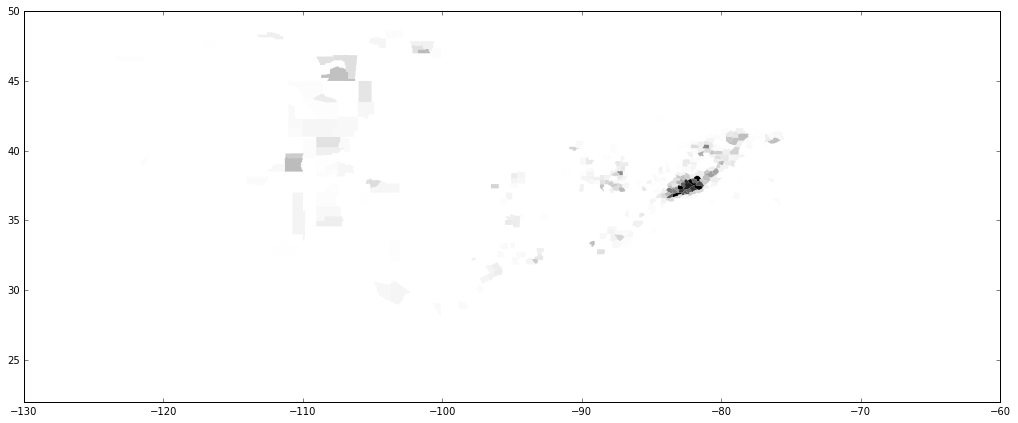

id           x           y                   industry_title    color  \
0  1142  219.031733  173.327239  NAICS 1142 Hunting and trapping  #0000f1   

   presence color_mfg_srv  
0  True      #D3D3D3

id           x           y                        industry_title  \
206  3112  209.725043  192.486758  NAICS 3112 Grain and oilseed milling   

       color  presence color_mfg_srv  
206  #00b0ff  True      #D3D3D3

id           x          y                  industry_title    color  \
93  1122  140.245095  185.54152  NAICS 1122 Hog and pig farming  #ff6800   

    presence color_mfg_srv  
93  True      #D3D3D3

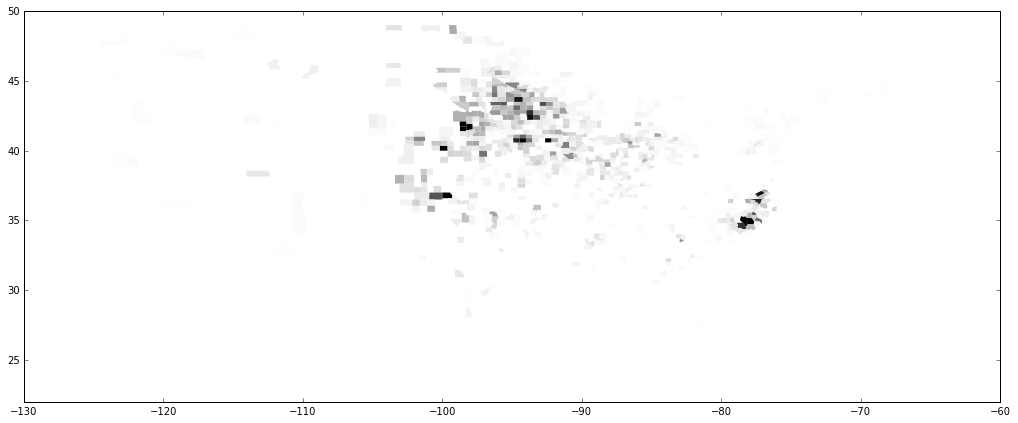

id           x          y  \
54  3133  210.434607  56.619886   

                                   industry_title    color  presence  \
54  NAICS 3133 Textile and fabric finishing mills  #00b0ff  True       

   color_mfg_srv  
54  #D3D3D3

id           x           y                     industry_title    color  \
16  3325  174.573324  103.741231  NAICS 3325 Hardware manufacturing  #00b0ff   

    presence color_mfg_srv  
16  True      #000080

id           x           y                          industry_title  \
32  3361  174.214169  122.008065  NAICS 3361 Motor vehicle manufacturing   

      color  presence color_mfg_srv  
32  #00b0ff  True      #000080

id           x           y  \
160  3365  177.710482  159.418747   

                                      industry_title    color  presence  \
160  NAICS 3365 Railroad rolling stock manufacturing  #ceff29  True       

    color_mfg_srv  
160  #000080

id           x           y  \
149  3369  163.510778  178.917803   

                                              industry_title    color  \
149  NAICS 3369 Other transportation equipment manufacturing  #00b0ff   

     presence color_mfg_srv  
149  True      #000080

id          x           y  \
308  4852  270.06568  155.783188   

                                         industry_title    color  presence  \
308  NAICS 4852 Interurban and rural bus transportation  #00b0ff  True       

    color_mfg_srv  
308  #D3D3D3

id           x           y  \
33  4862  219.317158  196.202277   

                                       industry_title    color  presence  \
33  NAICS 4862 Pipeline transportation of natural gas  #ceff29  True       

   color_mfg_srv  
33  #D3D3D3

id           x          y  \
258  6222  113.313489  155.84665   

                                           industry_title    color  presence  \
258  NAICS 6222 Psychiatric and substance abuse hospitals  #004cff  True       

    color_mfg_srv  
258  #D3D3D3

id           x          y                  industry_title    color  \
105  7132  252.217456  205.31451  NAICS 7132 Gambling industries  #004cff   

     presence color_mfg_srv  
105  True      #D3D3D3

id           x           y                     industry_title    color  \
138  3151  214.351753  134.071271  NAICS 3151 Apparel knitting mills  #0000f1   

     presence color_mfg_srv  
138  True      #D3D3D3

id          x          y                           industry_title  \
151  4811  222.09663 -59.466522  NAICS 4811 Scheduled air transportation   

       color  presence color_mfg_srv  
151  #000080  True      #D3D3D3

id           x          y  \
101  3272  288.079839 -34.915145   

                                       industry_title    color  presence  \
101  NAICS 3272 Glass and glass product manufacturing  #000080  True       

    color_mfg_srv  
101  #000080

id           x           y  \
66  4871  234.117107  120.106421   

                                            industry_title    color  presence  \
66  NAICS 4871 Scenic and sightseeing transportation, land  #004cff  True       

   color_mfg_srv  
66  #D3D3D3

id           x          y  \
178  3159  213.535097  90.627035   

                                             industry_title    color  \
178  NAICS 3159 Accessories and other apparel manufacturing  #00b0ff   

     presence color_mfg_srv  
178  True      #000080

id           x           y                              industry_title  \
144  3313  153.147144  132.847489  NAICS 3313 Alumina and aluminum production   

       color  presence color_mfg_srv  
144  #00b0ff  True      #D3D3D3

id          x           y  \
252  3342  66.975075 -138.439724   

                                        industry_title    color  presence  \
252  NAICS 3342 Communications equipment manufacturing  #000080  True       

    color_mfg_srv  
252  #000080

id           x           y  \
180  3161  197.029727  144.337556   

                                        industry_title    color  presence  \
180  NAICS 3161 Leather and hide tanning and finishing  #0000f1  True       

    color_mfg_srv  
180  #D3D3D3

id          x          y                           industry_title  \
5  5174  170.51806  33.146583  NAICS 5174 Satellite telecommunications   

     color  presence color_mfg_srv  
5  #00b0ff  True      #D3D3D3

id           x           y  \
143  3311  153.015864  112.981262   

                                          industry_title    color  presence  \
143  NAICS 3311 Iron and steel mills and ferroalloy mfg.  #00b0ff  True       

    color_mfg_srv  
143  #000080

id           x           y                    industry_title    color  \
302  4851  353.922447  117.821024  NAICS 4851 Urban transit systems  #000080   

     presence color_mfg_srv  
302  True      #D3D3D3

id           x           y  \
280  3352  162.479936  146.636297   

                                   industry_title    color  presence  \
280  NAICS 3352 Household appliance manufacturing  #00b0ff  True       

    color_mfg_srv  
280  #000080

id           x           y  \
276  5251  109.041651 -211.881882   

                                      industry_title    color  presence  \
276  NAICS 5251 Insurance and employee benefit funds  #000080  True       

    color_mfg_srv  
276  #D3D3D3

id           x           y                            industry_title  \
31  4869  275.410613  182.458382  NAICS 4869 Other pipeline transportation   

      color  presence color_mfg_srv  
31  #00b0ff  True      #D3D3D3

id           x           y  \
254  3341  107.885546 -134.937511   

                                        industry_title    color  presence  \
254  NAICS 3341 Computer and peripheral equipment mfg.  #000080  True       

    color_mfg_srv  
254  #000080

id           x          y  \
253  3343  166.150692  42.680327   

                                         industry_title    color  presence  \
253  NAICS 3343 Audio and video equipment manufacturing  #00b0ff  True       

    color_mfg_srv  
253  #000080

id           x           y                     industry_title    color  \
95  1124  180.419917  255.325456  NAICS 1124 Sheep and goat farming  #f10800   

    presence color_mfg_srv  
95  True      #D3D3D3

id           x           y  \
73  4879  185.471643  166.693878   

                                             industry_title    color  \
73  NAICS 4879 Scenic and sightseeing transportation, other  #0000f1   

    presence color_mfg_srv  
73  True      #D3D3D3

In [276]:
for naics in gdf['industry_code'].unique():
    display(nodes_.loc[nodes_.id == naics])
    if gdf.loc[gdf.industry_code == naics]['annual_avg_estabs'].mean() > .3: # Dismiss very small indus

        ax = gdf.loc[gdf.industry_code == naics].plot(
            column='annual_avg_estabs', cmap=plt.cm.gist_yarg, vmin = 0, vmax = 5, linewidth = 0, figsize = (17.5, 12))
        ax.set_xlim(-130, -60)
        ax.set_ylim(22, 50)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
        plt.show()

### Color by Population Density

In [29]:
processed_data_path = './../../../../../media/miglesia/Elements/corr_st_data/'

main_tables = pd.concat([pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2012_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2011.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2013.csv')])

main_table = main_tables.groupby('CHI ID COM').mean()/2.

# change node names into node index
# main_table.rename(columns = dict(zip(nodes.node_name, nodes.index)), inplace = True)

population = pd.read_csv('./data/pop_dist_comuna.csv').rename(columns = {'comuna_id': 'CHI ID COM'})

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [30]:
from numpy import log10
population['log_dens'] = log10(population['densidad'])
b = 8; population['log_dens_cat'] = pd.cut(population['log_dens'], b)

bins = pd.cut(population['log_dens'], b, retbins=True)[1]
bins_mean = (bins[1:] + bins[:-1])/2.

merged = pd.concat([population.set_index('CHI ID COM')[['log_dens_cat']].sort_index(), main_table], axis = 1)
popdens_RCA = RCA(merged.groupby('log_dens_cat').sum())

popdens_RCA_normed = popdens_RCA/popdens_RCA.sum()

In [32]:
nodes_

id           x            y  \
0               1142  438.063467   346.654478   
1               5173   48.061148  -376.352524   
2               1141  252.091609   396.823874   
3               3335   81.914174   141.836826   
4               5175  501.808425   599.194896   
5               5174  341.036119    66.293166   
6               5418 -264.160272  -538.654205   
7               5179  136.605474  -558.303920   
8               4238 -322.709905  -347.941691   
9           Woodland  410.096149   458.396185   
10              4412 -629.046352    95.587901   
11              7221 -592.869933    15.030814   
12              3321  100.303430   222.128215   
13              3322  221.626153    81.317555   
14              7222 -637.044779   -12.322761   
15              3324  254.351936   185.197645   
16              3325  349.146648   207.482461   
17              3326  138.365715   208.185043   
18              7114  246.621086  -219.524674   
19              3328  -26.786309    66.816615   
20              3329  -53.714379   203.871153   
21   POPESTIMATE2010 -550.258138   -59.114156   
22             Urban  200.232812   440.994041   
23              5172   36.023324  -676.715521   
24              3122  489.756426   385.741453   
25              3251  479.746695    76.282723   
26              3252  305.194269   168.068580   
27              3253  440.294378   523.563443   
28              9281  214.342522   147.673850   
29              3255  173.322039   103.498197   
30              3256  219.015364  -122.446885   
31              4869  550.821226   364.916765   
32              3361  348.428338   244.016130   
33              4862  438.634316   392.404555   
34              6241 -354.109665  -208.641822   
35              6242  860.611510  -222.355307   
36              4861  426.121167   312.045008   
37              6244 -709.741014    49.943863   
38              4831  439.929827   152.940009   
39              9271  289.006321   322.759655   
40              5152  216.765120   -57.521996   
41              8141 -206.653289  -888.136365   
42              4881  849.271237   -28.786005   
43              4882  419.190703   145.123847   
44              4883  523.226665   357.866804   
45              1151  356.723677   477.768606   
46              4885  212.364967  -947.405283   
47              1153  458.254075   464.126079   
48              1152  381.679923   777.240312   
49              3333  -31.263646  -220.062505   
50              3332    8.558114    25.528450   
51              3331  463.463398   428.766587   
52              3131  379.551592   297.506527   
53              3336  196.106770   192.126140   
54              3133  420.869213   113.239772   
55              3334  118.493823    66.347691   
56              5511 -356.168497  -569.477992   
57              4236 -239.784693  -648.442778   
58              3339   -8.630394   106.351070   
59              4234 -232.324669  -457.309059   
60              4233  139.855317  -741.000974   
61              4232   52.235290  -582.080474   
62              4231 -242.804897  -276.998663   
63              7121  525.917933   508.733651   
64              7113   68.286725  -614.949480   
65              5619 -170.961592  -675.419976   
66              4871  468.234214   240.212842   
67              3379  434.177261   462.907863   
68              4872  321.338920   419.368170   
69              5612  302.151141  -296.704072   
70              5613 -326.750259  -491.081022   
71              3241  541.598460   141.826220   
72              5611 -271.346768  -567.500151   
73              4879  370.943285   333.387757   
74              5617 -576.407602  -156.332248   
75              5614 -353.875094  -486.632516   
76              5615 -231.046809  -553.975349   
77              6112 -644.447003  -487.449165   
78              6114 -106.251337  -505.100092   
79              7223 -678.677263  -449.965162   
80              3323 -735.191306  -159.228722   


In [35]:
# pop_dens_index = pd.DataFrame((popdens_RCA_normed.T*bins_mean).T.sum(), columns = ['pop_dens_index'])
# pop_dens_index = pop_dens_index.reset_index().rename(columns={'index':'id'})
# nodes_ = nodes_.merge(pop_dens_index, on = 'id', how = 'left') # industry_title / node_name
# # nodes_['pop_dens_color_code'] = pd.cut(nodes_['pop_dens_index'], bins = 7, labels=False)

# from numpy import nan
# rainbow_colors = {0:'#9400D3', #Violet
# 1:'#4B0082', #Indigo
# 2:'#0000FF', #Blue
# 3:'#00FF00', #Green
# nan:'#D3D3D3',  #'#D3D3D3', #Gray
# 4:'#FFFF00', #Yellow
# 5:'#FF7F00', #Orange
# 6:'#FF0000'} #Red

# nodes_['color_2'] = pd.DataFrame(nodes_['pop_dens_color_code'].map(rainbow_colors))

# network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'

In [ ]:
ps = d3plus.ProductSpace(
id="name",
name="node_name",
color="color_2",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

In [ ]:
plt.hist(edges.weight_CHI_COM.values, 50)
plt.hist(edges_max_d.weight_CHI_COM.values, 50)
plt.show()